In [3]:
import numpy as np
import os
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.pipeline import make_pipeline
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Activation, Dropout, Dense, Flatten, Conv1D, MaxPooling1D
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence



In [4]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
new_directory = '/content/drive/MyDrive/English_CNN/'
os.chdir(new_directory)
print(os.getcwd())

/content/drive/MyDrive/English_CNN


In [6]:
file_path = '/content/drive/MyDrive/IMDB-Dataset.csv'

dat = pd.read_csv(file_path)
dat.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [8]:

data = dat.iloc[0:10000,:]
data['sentiment'] = data['sentiment'].map({'negative': 0, 'positive': 1})
data.head(5)

<ipython-input-8-5e254457b122>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sentiment'] = data['sentiment'].map({'negative': 0, 'positive': 1})


,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [9]:
# Function to handle negations
def handle_negation(text):
    negations = ["not", "no", "never", "none", "nothing", "nobody", "neither", "nor", "nowhere", "hardly", "scarcely", "barely", "don’t", "isn’t", "wasn’t", "shouldn’t", "wouldn’t", "couldn’t", "won’t"]
    tokens = word_tokenize(text)
    negated = False
    result = []
    for token in tokens:
        if token in negations:
            negated = not negated
        elif negated:
            result.append("NOT_" + token)
        else:
            result.append(token)
    return ' '.join(result)

In [10]:
# Preprocess text data
def preprocess_text(text):
    # Lowercasing and tokenizing
    text = re.sub(r'<.*?>', ' ', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s]', ' ', text)  # Remove punctuation
    text = text.lower()
    tokens = word_tokenize(text)

    # Stop words removal
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Negation handling
    text = handle_negation(' '.join(tokens))

    # Stemming
    stemmer = PorterStemmer()
    tokens = word_tokenize(text)
    tokens = [stemmer.stem(word) for word in tokens]

    return ' '.join(tokens)

In [11]:
# Apply preprocessing to each review
data['processed_review'] = data['review'].apply(preprocess_text)
data.head(5)


<ipython-input-11-c26deca5552e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['processed_review'] = data['review'].apply(preprocess_text)


,review,sentiment,processed_review
0,One of the other reviewers has mentioned that ...,1,one review mention watch 1 oz episod hook righ...
1,A wonderful little production. <br /><br />The...,1,wonder littl product film techniqu unassum old...
2,I thought this was a wonderful way to spend ti...,1,thought wonder way spend time hot summer weeke...
3,Basically there's a family where a little boy ...,0,basic famili littl boy jake think zombi closet...
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,petter mattei love time money visual stun film...


In [12]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['review'], data['sentiment'], test_size=0.2, random_state=19)


In [13]:
# Tokenization and padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['review'])
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
vocab_size = len(tokenizer.word_index) + 1
max_len = 100  # Adjust according to your choice


In [14]:
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')


In [20]:
# Define CNN model
model_cnn = Sequential()
model_cnn.add(Embedding(vocab_size, 100, input_length=max_len))
model_cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model_cnn.add(Flatten())
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dense(1, activation='sigmoid'))

model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Train the model
model_cnn.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_data=(X_test_pad, y_test))


Epoch 1/5
125/125 [==============================] - 28s 168ms/step - loss: 0.6191 - accuracy: 0.6137 - val_loss: 0.4021 - val_accuracy: 0.8195
Epoch 2/5
125/125 [==============================] - 16s 129ms/step - loss: 0.2580 - accuracy: 0.8919 - val_loss: 0.3781 - val_accuracy: 0.8375
Epoch 3/5
125/125 [==============================] - 16s 132ms/step - loss: 0.0418 - accuracy: 0.9877 - val_loss: 0.5293 - val_accuracy: 0.8375
Epoch 4/5
125/125 [==============================] - 16s 129ms/step - loss: 0.0051 - accuracy: 0.9998 - val_loss: 0.6618 - val_accuracy: 0.8270
Epoch 5/5
125/125 [==============================] - 17s 133ms/step - loss: 5.2654e-04 - accuracy: 1.0000 - val_loss: 0.7200 - val_accuracy: 0.8265


In [21]:
# Evaluate the model
loss, accuracy = model_cnn.evaluate(X_test_pad, y_test)
print("CNN Model Accuracy:", accuracy)


63/63 [==============================] - 1s 12ms/step - loss: 0.7200 - accuracy: 0.8265
CNN Model Accuracy: 0.8264999985694885


In [22]:
# Predictions
y_pred_prob = model_cnn.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype(int)

# Flatten the predictions array
y_pred_flat = y_pred.flatten()

63/63 [==============================] - 1s 7ms/step


In [23]:
# Classification Report
print(classification_report(y_test, y_pred_flat))

              precision    recall  f1-score   support

           0       0.82      0.83      0.82       989
           1       0.83      0.83      0.83      1011

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.83      0.83      0.83      2000



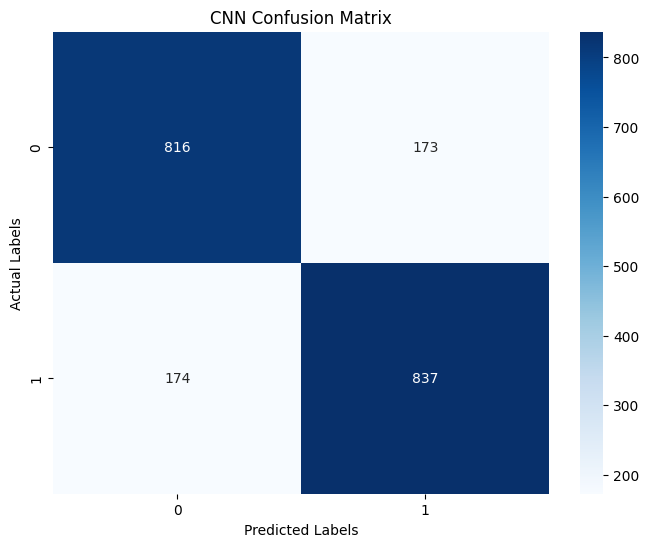

In [24]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_flat)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('CNN Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

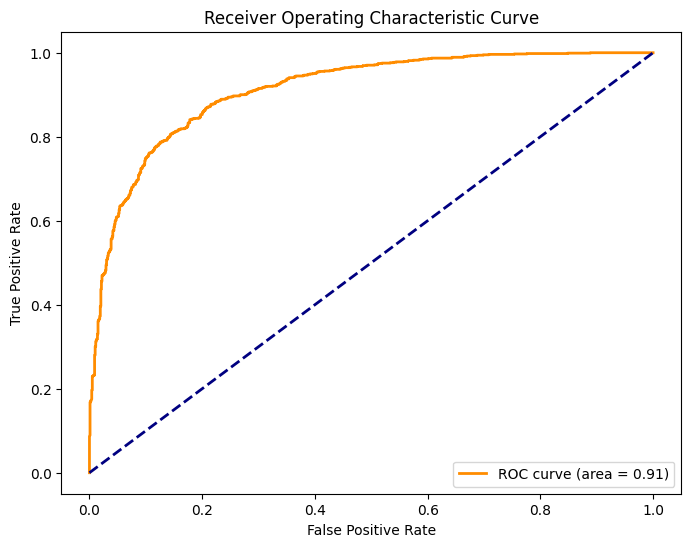

In [25]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()